In [1]:
import pymc as pm
import matplotlib.pyplot as plt
import pytensor.tensor as pt

# Import from chronologer (assuming `chronologer` is installed in your environment)
from chronologer.calcurves import load_calcurve
from chronologer.calibration import calibrate
from chronologer.pymccarbon import interpolate_calcurve

# Load IntCal20 (or other)
curve = load_calcurve("intcal20")

calbp = curve["calbp"]
c14bp = curve["c14bp"]
c14_sigma = curve["c14_sigma"]

Loading intcal20 from cache.
intcal20 has descending calbp (older to younger) implying positive BP values. Converting to negative BP (older more negative).


In [2]:
# Example radiocarbon date (BP)
r_mean = -4500
r_sigma = 30

cal_df = calibrate(
    radiocarbon_ages=[r_mean],
    radiocarbon_errors=[r_sigma],
    calcurve=curve,
    as_pandas=True
)

cal_df


,Radiocarbon Age,Mean Calibrated Age (BP),Std Dev (BP),HDI Intervals,Calibrated Distribution,CalBP Domain,Calibrated PDF
0,-4500,-13846.819359,14221.369334,"[(-5280.528052805283, -5275.027502750279), (-5...",<chronologer.distributions.calrcarbon object a...,"[-5440.044004400443, -5434.543454345439, -5429...","[3.5182218553832196e-07, 3.67449142202653e-06,..."


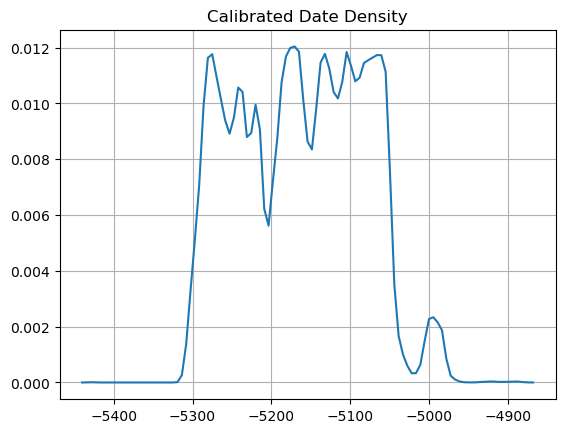

In [3]:
# Optional: plot the calibrated density (just for visual check)
tau = cal_df.iloc[0]['CalBP Domain']
pdf = cal_df.iloc[0]["Calibrated PDF"]

plt.plot(tau, pdf)
plt.grid(True)
plt.title("Calibrated Date Density")
plt.show()


In [4]:
# Example usage to create initial intcal20 dictionary
intcal20 = load_calcurve()

# recast calibration curve data as tensors for use in PyMC model context
calbp_tensor = pt.as_tensor_variable(intcal20['calbp'])
c14bp_tensor = pt.as_tensor_variable(intcal20['c14bp'])
c14_sigma_tensor = pt.as_tensor_variable(intcal20['c14_sigma'])


Loading intcal20 from cache.
intcal20 has descending calbp (older to younger) implying positive BP values. Converting to negative BP (older more negative).


In [13]:
hdi_intervals = cal_df.iloc[0]['HDI Intervals']

# Flatten the list of tuples into a single list of all values
all_values = [value for interval in hdi_intervals for value in interval]

# Find min and max
start = min(all_values)
end = max(all_values)

cal_early_bound = start * (1 - 0.3)
cal_late_bound = end * (1 + 0.3)

print( (cal_early_bound,cal_late_bound) )

(-3696.3696369636978, -6578.657865786585)


In [ ]:
r_mean = -4500
r_sigma = 30

# start and end are defined above by precalibrating using a faster method

with pm.Model() as model:
    # Step 1: Latent event age `tau'
    tau = pm.Uniform('tau', lower=-6000, upper=-4000)

    # Step 2: Define calibration model

    # calibration curve
    mean, error = interpolate_calcurve(tau, calbp_tensor, c14bp_tensor, c14_sigma_tensor)
    mean = mean[0]
    error = error[0]

    # true c14 measurement, which is latent
    r_latent = pm.Normal('r_latent', mu=mean, sigma=error)
    
    # measurement error model
    r_measured = pm.Normal('r_measured', mu=r_latent, sigma=r_sigma, observed=r_mean)

    # Sampling from the posterior
    step = pm.Metropolis()
    trace = pm.sample(draws=7000, tune=2000, step=step, chains = 1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>Metropolis: [r_latent]


/home/carleton@gea.mpg.de/miniconda3/envs/rapids/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 1 chain for 2_000 tune and 7_000 draw iterations (2_000 + 7_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<Axes: title={'center': 'r_latent'}>,
        <Axes: title={'center': 'r_latent'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>]],
      dtype=object)

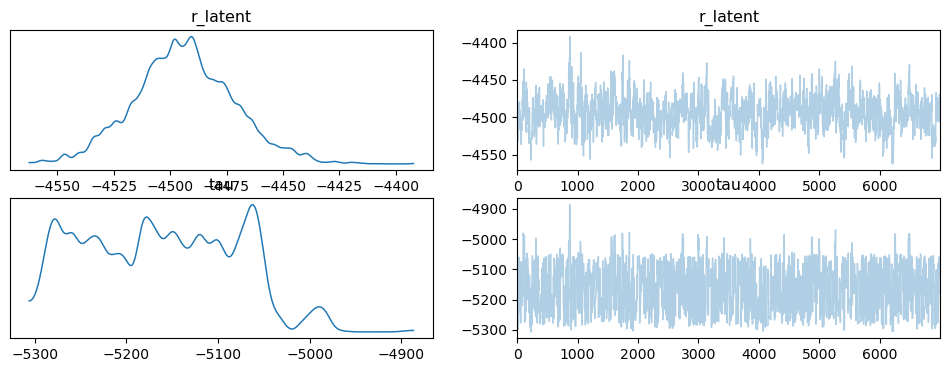

In [22]:
pm.plot_trace(trace)